In [73]:
import flopy
import numpy as np
import matplotlib.pyplot as plt
import shutil
from pathlib import Path


from datetime import datetime
from tempfile import TemporaryDirectory
from tempfile import mkdtemp

import os
import platform
import subprocess
#from shapely.geometry import Polygon, Point
#from scipy.interpolate import make_interp_spline

In [74]:
def open_file(path):
    if platform.system() == "Windows":
        os.startfile(path)
    elif platform.system() == "Darwin":
        subprocess.Popen(["open", path])
    else:
        subprocess.Popen(["xdg-open", path])

# Plot Results

In [ ]:
model_ws = "C:\\Users\\swan47\\AppData\\Local\\Temp\\_T1027115022_wasaga_c96bgfib" # HMOC
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:
# FDM 70 years
model_ws = 'C:\\Users\\swan47\\AppData\\Local\\Temp\\_T1027155237_wasaga_8w84q7ca' 
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:
model_ws = 'C:\\Users\\swan47\\AppData\\Local\\Temp\\_T1027151129_wasaga_pzvlih61' ## Heterogeneity , Sigma=2
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:
## Heterogeneity , Log Normal Sigma =0.4
model_ws = 'C:\\Users\\swan47\\AppData\\Local\\Temp\\_T1027200024_wasaga_4bbtdli5'
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:

## Langmuir 
model_ws = Path('C:/Users/swan47/Documents/Data/_wasaga_regional_local/_T1027204957_wasaga_xiniyo6w_langmuir')
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:


model_ws = '/Volumes/WD Green/Data/pmwin_projects/_T1027204957_wasaga_xiniyo6w_langmuir'
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:

model_ws = Path('/var/folders/hy/v14_l_r91tl2w5s9xfm9p2kc0000gn/T/_T1027235020_wasaga_722y1j58')
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

## GW Budget  test

In [ ]:
#T
model_ws = Path('C:/Users/swan47/AppData/Local/Temp/_T1113225454_wasaga_4scesssj')
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:
model_ws = Path('C:/Users/swan47/AppData/Local/Temp/_T1114011712_wasaga_hhe2cnnr')
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:
model_ws = Path('C:/Users/swan47/AppData/Local/Temp/_T1114024022_wasaga__5_pv4rn')
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:
model_ws = Path('C:/Users/swan47/AppData/Local/Temp/_T1114164044_wasaga_2cy8k67o') ##70 years
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:
model_ws = Path('C:/Users/swan47/AppData/Local/Temp/_T1115164527_wasaga_8g0heui5') ##70 years, updated icbund
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:
model_ws

In [ ]:
model_ws = Path('/var/folders/hy/v14_l_r91tl2w5s9xfm9p2kc0000gn/T/_T1125184206_wasaga_0s9zwl7u') ##70 years, updated icbund
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:
model_ws =  Path('C:\\Users\\swan47\\AppData\\Local\\Temp\\_T1126155437_wasaga_mcympo81') # new base model
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:

model_ws =  Path('C:\\Users\\swan47\\AppData\\Local\\Temp\\_T1126164037_wasaga_wi_39aij') # new fast conditions
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:

model_ws =  Path('C:\\Users\\swan47\\AppData\\Local\\Temp\\_T1126173234_wasaga_2r9_cyma') # new slower conditions
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:
model_ws =  Path('C:\\Users\\swan47\\AppData\\Local\\Temp\\_T1126174811_wasaga_gcs_jye6') # new fast conditions 500 years
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)


In [ ]:
model_ws = Path('/var/folders/hy/v14_l_r91tl2w5s9xfm9p2kc0000gn/T/_T1126231349_wasaga_i_3l1xt3') ## faster condition with lower dispersivity
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:

model_ws =  Path('/var/folders/hy/v14_l_r91tl2w5s9xfm9p2kc0000gn/T/_T1127092500_wasaga_6w77qvj_') # even faster conditions
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

## Comfort Station

In [ ]:

model_ws =  Path('C:\\Users\\swan47\\AppData\\Local\\Temp\\_T1207162357_wasaga_o5u9s4y2') # old base condition, comfort station
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:

model_ws =  Path('C:\\Users\\swan47\\AppData\\Local\\Temp\\_T1207175420_wasaga_5n5avyuh') # new base condition, comfort station,  no nearshore drain
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:
model_ws =  Path('C:\\Users\\swan47\\AppData\\Local\\Temp\\_T1207191219_wasaga_f80k7t8f') # new base condition, comfort station at 1250m,  no nearshore drain
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:
model_ws =  Path('C:\\Users\\swan47\\AppData\\Local\\Temp\\_T1208152949_wasaga_zok1vxe8') # new base condition, comfort station at 1250m,  no nearshore drain, 500 years
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:
model_ws =  Path('C:\\Users\\swan47\\AppData\\Local\\Temp\\_T1208174955_wasaga_rie7u9w2') # new base condition, comfort station at 1250m,  no nearshore drain, 500 years
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:
model_ws =  Path('C:\\Users\\swan47\\AppData\\Local\\Temp\\_T1213133434_wasaga_a4inkdh2') # new base condition, comfort station at 1250m,  with drain, 10 year , fine grid
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)



In [ ]:

model_ws =  Path('D:\\_T1213141439_wasaga_kd0ajh1w') # new base condition, comfort station 70m from beach,  with drain, 10 year , fine grid
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)



In [5]:


model_ws =  Path('C:\\Users\\swan47\\AppData\\Local\\Temp\\_T1213204545_wasaga_4xcfmuwd') # new base condition, comfort station 70m from beach,  with drain, 70 year , fine grid ## [moved to D]
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)



## Topography

In [4]:
model_ws =  Path('/var/folders/hy/v14_l_r91tl2w5s9xfm9p2kc0000gn/T/_T1221063806_wasaga_rb3xqkdp') #
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

## Drain Conductance

In [40]:

model_ws =  Path('/var/folders/hy/v14_l_r91tl2w5s9xfm9p2kc0000gn/T/_T1221085136_wasaga_u_d_bjei')  # 10
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:

model_ws =  Path('/var/folders/hy/v14_l_r91tl2w5s9xfm9p2kc0000gn/T/_T1221122318_wasaga_tucxxlkj')  # 1
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

## Real Septic data

In [35]:

model_ws =  Path('C:\\Users\\swan47\\AppData\\Local\\Temp\\_T0108211703_wasaga_jozjucwp')  # 56 years (if no sanitary   )
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [76]:
model_ws =  Path('C:\\Users\\swan47\\AppData\\Local\\Temp\\_T0109005814_wasaga_8t3rbwo4')  # 56 years 
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [68]:

model_ws =  Path('D:\\_T0110015920_wasaga_')  # 500 years
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

# DIS

In [ ]:
dis = model.dis
nrow = dis.nrow
ncol = dis.ncol
nlay = dis.nlay


delr = 2200/nrow
delc = 2200/ncol
layer_thickness = 30/nlay
nper = model.dis.nper

In [ ]:
open_file(model_ws)

# Cross-section


## Hydraulic Head

c:\Users\swan47\Miniconda3\envs\pht3d\Lib\site-packages\flopy\plot\crosssection.py:562: UserWarning: Warning: converting a masked element to nan.
  plotarray = np.array([a[cell] for cell in sorted(self.projpts)])


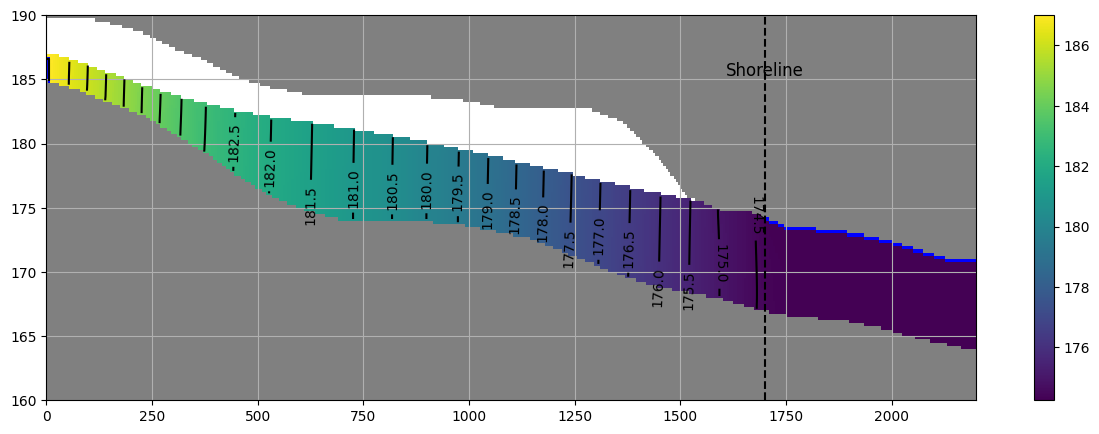

In [69]:
fig = plt.figure(figsize=(15, 5))
xsect = flopy.plot.PlotCrossSection(model=model, line={"Column": 146})

hds = flopy.utils.binaryfile.HeadFile(model_ws / 'example_model.hds')
head_data = hds.get_data(kstpkper=(0, 0)) # (time step, stress period)

ibd = model.bas6.ibound.array
masked_head_data = np.ma.masked_where(ibd== 0, head_data)

cs = xsect.plot_array(masked_head_data, cmap="viridis")
plt.colorbar(cs)

contour_levels = np.arange(164, 188, 0.5)
#contour_levels = np.arange(173, 177, 0.1)

contour_set = xsect.contour_array(masked_head_data, levels=contour_levels, colors="black")
plt.clabel(contour_set, inline=True, fontsize=10, fmt="%1.1f")
plt.grid()

ibd = xsect.plot_ibound(color_noflow='grey')
#ibd.set_facecolor("red")  # set the color of the masked cells to grey

plt.axvline(x=1700, color='black', linestyle='--')

plt.text(1700, 185, 'Shoreline', ha='center', va='bottom', fontsize=12)
# plt.xlim(1600,1750)
# plt.ylim(165,180)

# plt.axvline(x=1700-70, color='r') #source
# plt.axvline(x=1700-70+20, color='k') #source
# plt.axvline(x=1700-70+40, color='k') #source
# plt.axvline(x=1700-70+60, color='k') #source


#xs = drn_ys
#ys = [ lay_to_meter(locate_ground_surface_lay(meter_to_row(y))) for y in drn_ys]
#plt.scatter([x - 0.0 for x in xs],[y- 0.0 for y in ys],c='r',marker='s',s=5)

plt.savefig(Path(model_ws)/'_output/hds.png')

In [ ]:
open_file(model_ws)

In [71]:
open_file(model_ws)

In [70]:
### read data

col = int(ncol/3)
col = 146
ibound = model.bas6.ibound.array
ucnobj = flopy.utils.binaryfile.UcnFile(model_ws / 'MT3D001.UCN')

# for kper in range(nper):
for kper in [55]:
    # Read the concentration data from the UCN file
    
    concentration_array = ucnobj.get_data(kstpkper=(0, kper))# (time step, stress period)

    # Mask the inactive cells
    mask = ((ibound== 0)|(concentration_array>=1e30))
    masked_conc_data = np.ma.masked_where(mask, concentration_array)

    ### plotting# #######
    fig = plt.figure(figsize=(15, 4))
    line = {"Column": col}

    # Create a PlotCrossSection object for the model
    xsect = flopy.plot.PlotCrossSection(model=model, line=line)

    # Plot the concentration results
    cs = xsect.plot_array(masked_conc_data, cmap='coolwarm', vmin=0.1, vmax=500)
    plt.colorbar(cs)
    ibd = xsect.plot_ibound(color_noflow='grey')
    plt.title('col:{:03}, kper:{:02}'.format(col,kper))
    plt.savefig(Path(model_ws)/'_output/conc_{:02}.png'.format(kper))
    plt.clf()

##--------

<Figure size 1500x400 with 0 Axes>

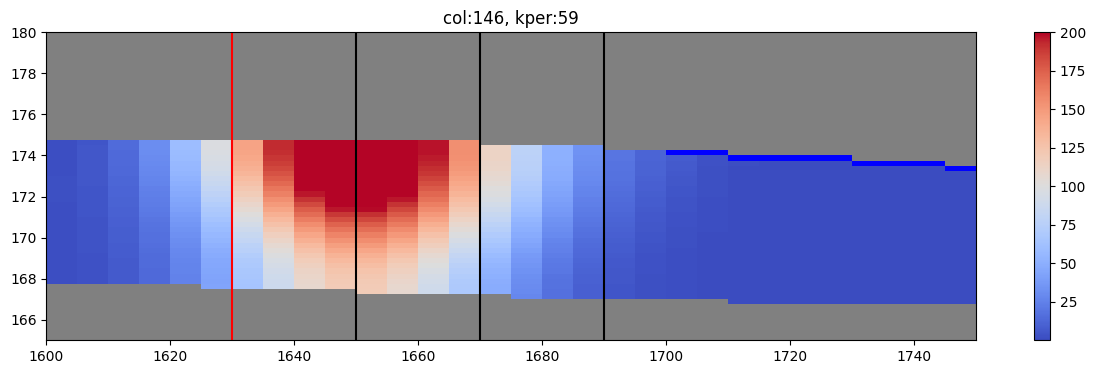

In [ ]:
### close up image

col = int(ncol/3)
ibound = model.bas6.ibound.array
ucnobj = flopy.utils.binaryfile.UcnFile(model_ws / 'MT3D001.UCN')

# for kper in range(nper):
for kper in [59]:
    # Read the concentration data from the UCN file
    
    concentration_array = ucnobj.get_data(kstpkper=(0, kper))# (time step, stress period)

    # Mask the inactive cells
    mask = ((ibound== 0)|(concentration_array>=1e30))
    masked_conc_data = np.ma.masked_where(mask, concentration_array)

    ### plotting# #######
    fig = plt.figure(figsize=(15, 4))
    line = {"Column": col}

    # Create a PlotCrossSection object for the model
    xsect = flopy.plot.PlotCrossSection(model=model, line=line)

    # Plot the concentration results
    cs = xsect.plot_array(masked_conc_data, cmap='coolwarm', vmin=0.1, vmax=200)
    plt.colorbar(cs)
    ibd = xsect.plot_ibound(color_noflow='grey')
    plt.title('col:{:03}, kper:{:02}'.format(col,kper))
    plt.xlim(1600,1750)
    plt.ylim(165,180)

    plt.axvline(x=1700-70, color='r') #source
    plt.axvline(x=1700-70+20, color='k') #source
    plt.axvline(x=1700-70+40, color='k') #source
    plt.axvline(x=1700-70+60, color='k') #source
    #plt.savefig(Path(model_ws)/'_output/conc_{:02}.png'.format(kper))
    #plt.clf()

##--------

## Row View Xsect

5.0

730.0

In [46]:
### read data

#col = int(ncol/3)
row =  int((1700-70+20+20+20)/(delc))
ibound = model.bas6.ibound.array
ucnobj = flopy.utils.binaryfile.UcnFile(model_ws / 'MT3D001.UCN')

# for kper in range(nper):
for kper in [59]:
    # Read the concentration data from the UCN file
    
    concentration_array = ucnobj.get_data(kstpkper=(0, kper))# (time step, stress period)

    # Mask the inactive cells
    mask = ((ibound== 0)|(concentration_array>=1e30))
    masked_conc_data = np.ma.masked_where(mask, concentration_array)

    ### plotting# #######
    fig = plt.figure(figsize=(15, 4))
    line = {"Row": row}

    # Create a PlotCrossSection object for the model
    xsect = flopy.plot.PlotCrossSection(model=model, line=line)

    # Plot the concentration results
    cs = xsect.plot_array(masked_conc_data, cmap='coolwarm', vmin=0.1, vmax=300)
    plt.colorbar(cs)
    ibd = xsect.plot_ibound(color_noflow='grey')
    plt.title('row:{:03}, kper:{:02}'.format(row,kper))
    plt.xlim(700,760)
    plt.ylim(166,176)
    plt.savefig(Path(model_ws)/'_output/conc_rowview_row{:02}_{:02}.png'.format(row,kper))
    
    plt.clf()

##--------

Exception: get_data() error: kstpkper not found:(0, 59)

# GW Budget

In [36]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [37]:
cbc = flopy.utils.CellBudgetFile(model_ws /'example_model.cbc', model=model)

times = cbc.get_times()
fff = cbc.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]
frf = cbc.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]
flf = cbc.get_data(text='FLOW LOWER FACE', totim=times[-1])[0]
faf = flf + fff + frf


In [38]:
ch  = cbc.get_data(text='CONSTANT HEAD', totim=times[0])[0]

0
1
2
3
4
5
6
7
8
9


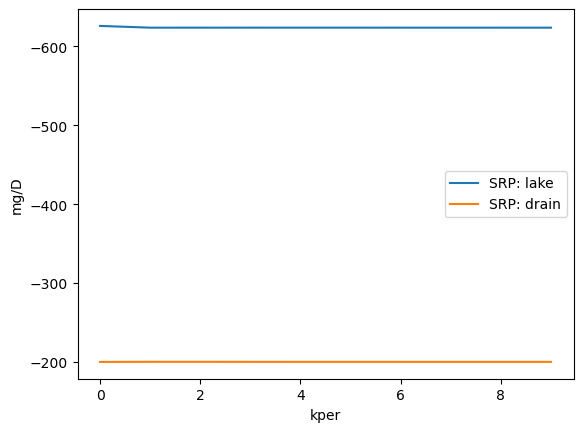

In [48]:
cbc = flopy.utils.CellBudgetFile(model_ws /'example_model.cbc', model=model)
ucnobj = flopy.utils.binaryfile.UcnFile(model_ws / 'MT3D001.UCN')

times = cbc.get_times()
xs = []
ys = []
ys1 =[]
ys2 = []
for n in range(len(times)):
    print(n)
    ucn= ucnobj.get_data( totim=times[n])
    ucn[ucn==1e30]=0

    ch  = cbc.get_data(text='CONSTANT HEAD', totim=times[n])[0]
    ch2 = [(np.unravel_index(i[0],(nlay,nrow,ncol)),i[1]) for i in ch]
    ch3 = [i for i in ch2 if i[0] if i[0][1]>float(2200/2/delr)] ## lake
    #print(np.sum([i[1] for i in ch3]))

    dr = cbc.get_data(text='DRAINS', totim=times[n])[0]

    dr2 = [(np.unravel_index(i[0],(nlay,nrow,ncol)),i[1]) for i in dr]
    dr3 = [i for i in dr2 if i[0] if i[0][1]>float(2200/2/delr)] ## lakeshore
    #print(np.sum([i[1] for i in dr3]))

    dr4 = [i for i in dr2 if i[0] if i[0][1]<float(2200/2/delr)] ## upland
    #print(np.sum([i[1] for i in dr4]))


    ys.append(0.51*-5000*2)
    ys1.append(np.sum([1*i[1] for i in ch3]))
    ys2.append(np.sum([1*i[1] for i in dr3]))
    xs.append(n)

#plt.plot(xs,ys,label='SRP: input')
plt.plot(xs,ys1,label='SRP: lake')
plt.plot(xs,ys2,label = 'SRP: drain')
plt.xlabel('kper')
plt.ylabel('mg/D')
plt.gca().invert_yaxis()
plt.legend()

0
1
2
3
4
5
6
7
8
9


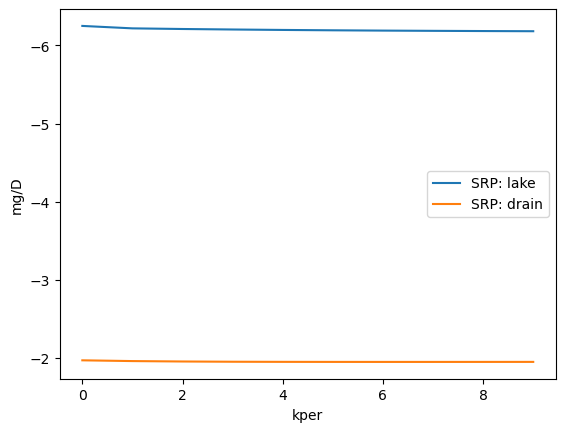

In [45]:
cbc = flopy.utils.CellBudgetFile(model_ws /'example_model.cbc', model=model)
ucnobj = flopy.utils.binaryfile.UcnFile(model_ws / 'MT3D001.UCN')

times = cbc.get_times()
xs = []
ys = []
ys1 =[]
ys2 = []
for n in range(len(times)):
    print(n)
    ucn= ucnobj.get_data( totim=times[n])
    ucn[ucn==1e30]=0

    ch  = cbc.get_data(text='CONSTANT HEAD', totim=times[n])[0]
    ch2 = [(np.unravel_index(i[0],(nlay,nrow,ncol)),i[1]) for i in ch]
    ch3 = [i for i in ch2 if i[0] if i[0][1]>float(2200/2/delr)] ## lake
    #print(np.sum([i[1] for i in ch3]))

    dr = cbc.get_data(text='DRAINS', totim=times[n])[0]

    dr2 = [(np.unravel_index(i[0],(nlay,nrow,ncol)),i[1]) for i in dr]
    dr3 = [i for i in dr2 if i[0] if i[0][1]>float(2200/2/delr)] ## lakeshore
    #print(np.sum([i[1] for i in dr3]))

    dr4 = [i for i in dr2 if i[0] if i[0][1]<float(2200/2/delr)] ## upland
    #print(np.sum([i[1] for i in dr4]))


    ys.append(0.51*-5000*2)
    ys1.append(np.sum([ucn[i[0]]*i[1] for i in ch3]))
    ys2.append(np.sum([ucn[i[0]]*i[1] for i in dr3]))
    xs.append(n)

#plt.plot(xs,ys,label='SRP: input')
plt.plot(xs,ys1,label='SRP: lake')
plt.plot(xs,ys2,label = 'SRP: drain')
plt.xlabel('kper')
plt.ylabel('mg/D')
plt.gca().invert_yaxis()
plt.legend()

In [ ]:
#plt.plot(xs,ys,label='SRP: input')
plt.plot(xs,np.array(ys1) + np.array(ys2),label='SRP: lake + drain')

plt.xlabel('kper')
plt.ylabel('mg/D')
plt.gca().invert_yaxis()
plt.legend()
plt.ylim(0,-1500)

In [ ]:
ys5 = np.cumsum(np.add(ys1,ys2))*365/1000/1000

plt.plot(xs,ys5,marker='.')

plt.xlabel('kper (year)')
plt.ylabel('Cumative SRP (kg) (Total, Drain + Lake)')
plt.gca().invert_yaxis()
plt.title('cumulative SRP discharge to lake (kg)')
plt.ylim(0,-120)

In [ ]:
ys5 = np.cumsum(np.add(ys1,ys2))*365/1000/1000

plt.plot(xs,ys5,marker='.')

plt.xlabel('kper (year)')
plt.ylabel('Cumative SRP (kg) (Total, Drain + Lake)')
plt.gca().invert_yaxis()
plt.title('cumulative SRP discharge to lake (kg)')
plt.ylim(0,-120)

In [ ]:
ys5[-1]

In [ ]:
ch  = cbc.get_data(text='CONSTANT HEAD', totim=times[-1])[0]
ch2 = [(np.unravel_index(i[0],(120,220,220)),i[1]) for i in ch]
ch3 = [i for i in ch2 if i[0] if i[0][1]>float(2200/2/delr)] ## lake
print(np.sum([i[1] for i in ch3]))

ch4 = [i for i in ch2 if i[0] if i[0][1]<float(2200/2/delr)] ## upland
print(np.sum([i[1] for i in ch4]))

#ch3_minus_one = [[i[0][0]-1,i[0][1],i[0][2]] for i in ch3] # water

In [ ]:
dr = cbc.get_data(text='DRAINS', totim=times[-1])[0]


dr2 = [(np.unravel_index(i[0],(120,220,220)),i[1]) for i in dr]

dr3 = [i for i in dr2 if i[0] if i[0][1]>float(2200/2/delr)] ## lakeshore
print(np.sum([i[1] for i in dr3]))


dr4 = [i for i in dr2 if i[0] if i[0][1]<float(2200/2/delr)] ## upland
print(np.sum([i[1] for i in dr4]))

#ch3_minus_one = [[i[0][0]-1,i[0][1],i[0][2]] for i in ch3] # water

In [ ]:
cbc.list_unique_records()

## Constant Head (Lake)

In [ ]:
idx= np.where((ibound==-1))
filter = idx[1]>50
idx =(idx[0][filter],idx[1][filter],idx[2][filter])
faf[idx].sum() #m3 per day

In [ ]:
cbc = flopy.utils.CellBudgetFile(model_ws /'test.cbc', model=model)
ucnobj = flopy.utils.binaryfile.UcnFile(model_ws / 'MT3D001.UCN')

times = cbc.get_times()
xs = []
ys = []
for n in range(len(times)):
    t = times[n]
    fff = cbc.get_data(text='FLOW FRONT FACE', totim=t)[0]
    frf = cbc.get_data(text='FLOW RIGHT FACE', totim=t)[0]
    flf = cbc.get_data(text='FLOW LOWER FACE', totim=t)[0]
    faf = flf + fff + frf
    ucn= ucnobj.get_data( totim=t)

    gw_flow = faf[idx]
    gw_flux = gw_flow.sum() #m3 per day
    ucn_flux = (gw_flow * ucn[idx]).sum()
    ys.append(ucn_flux)
    xs.append(n)
    print(ucn_flux)

plt.scatter(xs,ys)


## Drain (near shore)

In [ ]:
drn = model.drn
i0 = np.array([i[0] for i in drn.stress_period_data.data[0]])
i1 = np.array([i[1] for i in drn.stress_period_data.data[0]])
i2 = np.array([i[2] for i in drn.stress_period_data.data[0]])
drn_idx = (i0,i1,i2)


filter = drn_idx[1]>100
drn_idx =(drn_idx[0][filter],drn_idx[1][filter],drn_idx[2][filter])

faf[drn_idx].sum()

In [ ]:
cbc = flopy.utils.CellBudgetFile(model_ws /'test.cbc', model=model)
ucnobj = flopy.utils.binaryfile.UcnFile(model_ws / 'MT3D001.UCN')

times = cbc.get_times()

xs = []
ys = []

for n in range(len(times)):
    t = times[n]
    fff = cbc.get_data(text='FLOW FRONT FACE', totim=t)[0]
    frf = cbc.get_data(text='FLOW RIGHT FACE', totim=t)[0]
    flf = cbc.get_data(text='FLOW LOWER FACE', totim=t)[0]
    faf = flf + fff + frf
    ucn= ucnobj.get_data( totim=t)

    gw_flow = faf[drn_idx]
    gw_flux = gw_flow.sum() #m3 per day
    ucn_flux = (gw_flow * ucn[drn_idx]).sum() * 365 /1000/1000
    ys.append(ucn_flux)
    xs.append(n)
    print(ucn_flux)

plt.plot(xs,ys,marker='o')
plt.gca().invert_yaxis()
#plt.ylim(0,-2000)
plt.xlabel('kper')
plt.ylabel('SRP mass flux (kg)')
plt.title('Drain (nearshore)')

## vertical boundary

In [ ]:
ibound = model.bas6.ibound.array

In [ ]:
idx= np.where((ibound !=0))
distance = 1690
distance = 1510
filter = idx[1]==int(distance/delr)
idx =(idx[0][filter],idx[1][filter],idx[2][filter])
faf[idx].sum() #m3 per day

In [ ]:
fff[idx].sum()

In [ ]:
cbc = flopy.utils.CellBudgetFile(model_ws /'example_model.cbc', model=model)
ucnobj = flopy.utils.binaryfile.UcnFile(model_ws / 'MT3D001.UCN')

times = cbc.get_times()
xs = []
ys = []
for n in range(len(times)):
    t = times[n]
    fff = cbc.get_data(text='FLOW FRONT FACE', totim=t)[0]
    frf = cbc.get_data(text='FLOW RIGHT FACE', totim=t)[0]
    flf = cbc.get_data(text='FLOW LOWER FACE', totim=t)[0]
    faf = abs(fff) +abs(frf) +abs(flf)
    faf = np.sqrt(abs(fff)**2 +abs(frf)**2 +abs(flf)**2)
    ucn= ucnobj.get_data( totim=t)

    gw_flow = faf[idx]
    gw_flux = gw_flow.sum() #m3 per day
    ucn_flux = (gw_flow * ucn[idx]).sum() 
    ys.append(ucn_flux)
    xs.append(n)
    print(ucn_flux)

plt.plot(xs,ys,marker='o')
#plt.gca().invert_yaxis()
plt.ylim(0,8000)
plt.xlabel('kper')
plt.ylabel('SRP mass flux (mg/D)')
plt.title('x={}'.format(distance))


## aqueous phase

In [ ]:
cmass_aq =[]
cmass_in = []
cmass_solid = []
kpers = []
ucnobj_aq = flopy.utils.binaryfile.UcnFile(model_ws + '/MT3D001.UCN')
ucnobj_solid = flopy.utils.binaryfile.UcnFile(model_ws + '/MT3D001S.UCN')
for kper in range(nper):

    # Read the concentration data from the UCN file
    if kper==0:
        source_mass = 0
    else:
        source_mass += 365*0.51*5000*2
    
    conc_array = ucnobj_aq.get_data(kstpkper=(0, kper))# (time step, stress period)
    conc_array[np.where(conc_array==1e30)] = 0
    conc_array[np.where(ibound!=1)] = 0
    c_aq = conc_array[np.where(conc_array>0.11)].sum()
    mass_aq = c_aq*delr*delc*layer_thickness* 0.25

    conc_array = ucnobj_solid.get_data(kstpkper=(0, kper))# (time step, stress period)
    conc_array[np.where(conc_array==1e30)] = 0
    conc_array[np.where(ibound!=1)] = 0
    c_solid = conc_array[np.where(conc_array>1e-7)].sum()
    mass_solid = c_solid*delr*delc*layer_thickness * 1.65E+09

    cmass_in.append(source_mass)
    cmass_aq.append(mass_aq)
    cmass_solid.append(mass_solid)
    kpers.append(kper)

ys = np.array(cmass_aq)
ys2 = np.array(cmass_in)
ys3 = np.array(cmass_solid)
ys4 = np.array(ys+ys3)
xs = kpers



plt.ylabel('Totoal SRP mass (mg))')
#plt.xticks(np.linspace(0,nper,5))
plt.xlabel('Stress Period (Year)')
#plt.title('mass_flux (input - output): {} '.format(cmass_in[-1] - cmass[-1]))
plt.plot(xs,ys4,marker='o',label='aq + solid')
plt.plot(xs,ys2,marker='o',label= 'input')
plt.legend()
plt.savefig(Path(model_ws)/'_output' /'mass.png')

In [ ]:
cmass =[]
cmass_in = []
kpers = []
ucnobj = flopy.utils.binaryfile.UcnFile(model_ws + '/MT3D001S.UCN')
for kper in range(nper):

    # Read the concentration data from the UCN file
    if kper==0:
        source_mass = 0
    else:
        source_mass += 365*0.51*5000*2
    
    concentration_array = ucnobj.get_data(kstpkper=(0, kper))# (time step, stress period)
    concentration_array[np.where(concentration_array==1e30)] = 0
    concentration_array[np.where(ibound!=1)] = 0

    csum = concentration_array[np.where(concentration_array>1e-6)].sum()
    mass = csum*delr*delc*layer_thickness * 1.65E+09

    cmass_in.append(source_mass)
    cmass.append(mass)
    kpers.append(kper)

ys = np.array(cmass)/1000/1000
ys2 = np.array(cmass_in)/1000/1000
xs = kpers



plt.ylabel('Totoal SRP mass (mg))')
#plt.xticks(np.linspace(0,nper,5))
plt.xlabel('Stress Period (Year)')
plt.title('mass_flux (input - output): {} '.format(cmass_in[-1] - cmass[-1]))
plt.plot(xs,ys,marker='o',label='output')
plt.plot(xs,ys2,marker='o',label= 'input')
plt.legend()
plt.savefig(Path(model_ws)/'_output' /'mass_sorbed.png')

# MapView

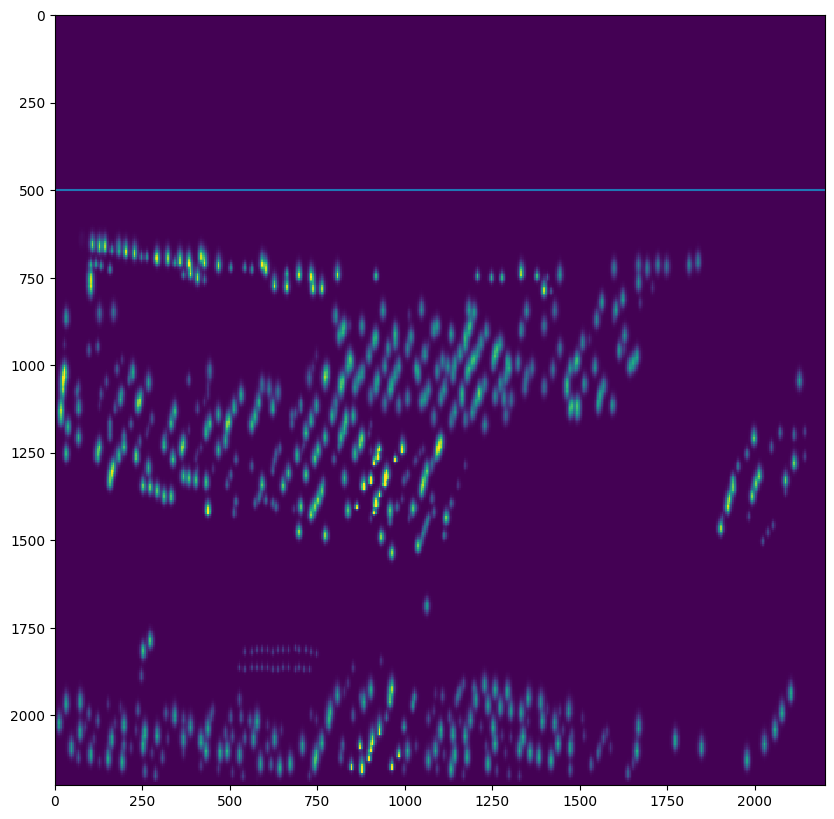

In [61]:
ucnobj = flopy.utils.binaryfile.UcnFile(Path(model_ws) / 'MT3D001.UCN')
times = ucnobj.get_times()
conc = ucnobj.get_data(totim=times[-1])  # get the concentration data for the last time step
conc[np.where(conc==1e30)] = 0
conc_sum = np.sum(conc, axis=0)
mapview = flopy.plot.PlotMapView(model=model)
fig = mapview.plot_array(conc_sum,vmin=0,vmax=10000)
plt.axhline(y=2200-1700)
plt.gca().invert_yaxis()
plt.gcf().set_size_inches(10,10)
plt.show()

In [7]:
# import os
# import flopy
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.cm import ScalarMappable
# from pathlib import Path

# # Define the UCN file and output folder
# ucnobj = flopy.utils.binaryfile.UcnFile(Path(model_ws) / 'MT3D001.UCN')
# output_folder = Path(model_ws) / '_output' / 'concentration_maps'

# # Create the output folder if it doesn't exist
# output_folder.mkdir(parents=True, exist_ok=True)

# # Get the times and loop through each time period
# times = ucnobj.get_times()

# for kper, totim in enumerate(times):
#     # Get concentration data for the current time step
#     conc = ucnobj.get_data(totim=totim)
#     conc[np.where(conc == 1e30)] = 0
#     conc_sum = np.sum(conc, axis=0)

#     # Create a map view plot
#     fig, ax = plt.subplots(figsize=(10, 10))
#     mapview = flopy.plot.PlotMapView(model=model)
#     mapview.plot_array(conc_sum, vmin=0, vmax=10000, ax=ax)
#     plt.axhline(y=2200-1700)
#     plt.gca().invert_yaxis()

#     # Create a dummy image for the colorbar
#     sm = ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=10000))
#     sm.set_array([])

#     # Add a colorbar with the sum of concentrations in all layers
#     cbar = plt.colorbar(sm, ax=ax, label='Sum of conc in all layers')

#     # Calculate the year based on kper
#     year = kper + 1968

#     # Set the title of the plot with the current year
#     plt.title(f'Concentration Map - Year {year}')

#     # Save the plot to the output folder
#     output_file = output_folder / f'concentration_map_year_{year}.png'
#     plt.savefig(output_file, bbox_inches='tight')
#     plt.close()

# # Print a message when all plots are saved
# print(f'All concentration maps saved to {output_folder}')




All concentration maps saved to C:\Users\swan47\AppData\Local\Temp\_T0108211703_wasaga_jozjucwp\_output\concentration_maps


In [22]:
output_folder

WindowsPath('C:/Users/swan47/AppData/Local/Temp/_T0108211703_wasaga_jozjucwp/_output/concentration_maps')

In [70]:
import os
import flopy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from pathlib import Path

# Assuming 'model_ws' and 'model' variables are defined and valid
ucnobj = flopy.utils.binaryfile.UcnFile(Path(model_ws) / 'MT3D001.UCN')
output_folder = Path(model_ws) / '_output' / 'concentration_maps'

output_folder.mkdir(parents=True, exist_ok=True)

times = ucnobj.get_times()
image_files = []

for kper, totim in enumerate(times):

    conc = ucnobj.get_data(totim=totim)
    conc[np.where(conc == 1e30)] = 0
    conc_sum = np.sum(conc, axis=0)

    fig, ax = plt.subplots(figsize=(10, 10))
    mapview = flopy.plot.PlotMapView(model=model)
    mapview.plot_array(conc_sum, vmin=0, vmax=10000, ax=ax)
    plt.axhline(y=2200-1700)
    plt.gca().invert_yaxis()
    plt.title(f'Concentration Map - Year {year}', pad=20)

    sm = ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=10000))
    sm.set_array([])
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = plt.colorbar(sm, cax=cax, label='Sum of conc in all layers')
    year = totim/365 + 1968
    year = round(year,1)
    
    output_file = output_folder / f'concentration_map_year_{year}.png'
    plt.savefig(output_file, bbox_inches='tight',dpi=300)
    plt.close()
    image_files.append(output_file)

print(f'All concentration maps saved to {output_folder}')

All concentration maps saved to D:\_T0110015920_wasaga_\_output\concentration_maps


### Video

In [72]:
import cv2

# Parameters for video creation
frame_duration = 0.05  # Duration of each image in the video
fps = int(1 / frame_duration)  # Frames per second
video_output = output_folder / 'concentration_video.mp4'

# Read the first image to determine the video resolution
frame = cv2.imread(str(image_files[0]))
height, width, layers = frame.shape

size = (width, height)

# Initialize video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can change the codec if needed
video = cv2.VideoWriter(str(video_output), fourcc, fps, size)

# Add images to video
for image_file in image_files:
    frame = cv2.imread(str(image_file))
    if frame.shape[1] != width or frame.shape[0] != height:
        raise ValueError(f"Image {image_file} has different size. All images must have the same dimensions.")
    video.write(frame)

# Release the video writer
video.release()
print(f"Video saved as {video_output}")


Video saved as D:\_T0110015920_wasaga_\_output\concentration_maps\concentration_video.mp4


In [54]:
width*2

1900

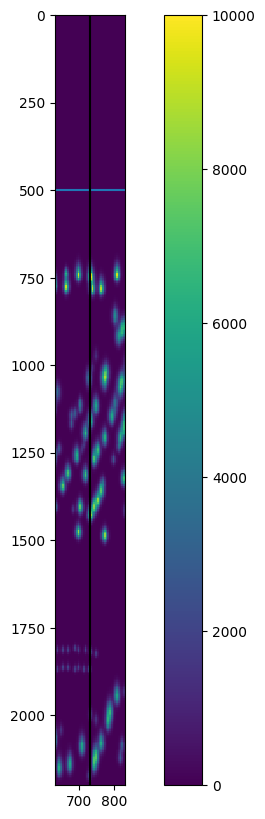

In [77]:
ucnobj = flopy.utils.binaryfile.UcnFile(Path(model_ws) / 'MT3D001.UCN')
times = ucnobj.get_times()
conc = ucnobj.get_data(totim=times[-10])  # get the concentration data for the last time step
conc[np.where(conc==1e30)] = 0
conc_sum = np.sum(conc, axis=0)
mapview = flopy.plot.PlotMapView(model=model)
fig = mapview.plot_array(conc_sum,vmin=0,vmax=10000)
plt.colorbar(fig)
plt.axhline(y=2200-1700)
plt.gca().invert_yaxis()
plt.xlim(146*5-100,146*5+100)
plt.axvline(x=146*5,c='k')
#plt.ylim(900,450)
plt.gcf().set_size_inches(10,10)
plt.show()

In [64]:
nper = model.dis.nper
ucnobj = flopy.utils.binaryfile.UcnFile(Path(model_ws) / 'MT3D001.UCN')
#for kper in range(nper)[::5]:
for kper in [3,17,59]:


    ucnobj = flopy.utils.binaryfile.UcnFile(Path(model_ws)/'MT3D001.UCN')
    times = ucnobj.get_times()
    conc = ucnobj.get_data(kstpkper=(0, kper))
    conc[np.where(conc==1e30)] = 0
    conc_sum = np.sum(conc, axis=0)
    conc_sum = np.flipud(conc_sum)
    mapview = flopy.plot.PlotMapView(model=model)
    fig = mapview.plot_array(conc_sum, cmap='coolwarm', vmin=0, vmax=800)
    #plt.show()

    plt.title('kper:{:02}'.format(kper))
    plt.xlim(650,850)
    plt.ylim(1550,1750)
    plt.colorbar(fig)
    plt.axhline(1700,c='k',linestyle = 'dashed')
    plt.axhline(1700-70,c='r')
    plt.axhline(1700-70+20,c='k')
    plt.axhline(1700-70+40,c='k')
    plt.axhline(1700-70+60,c='k')

    plt.savefig(Path(model_ws)/'_output'/'map_conc_{:02}'.format(kper))

    
    
    
    plt.clf()

Exception: get_data() error: kstpkper not found:(0, 59)

<Figure size 640x480 with 0 Axes>

In [ ]:
open_file(model_ws)

In [ ]:
kper = 18
lay = int(nlay/2)

fig = plt.figure(figsize=(15, 5))
mapview = flopy.plot.PlotMapView(model=model, layer=lay)
ucnobj = flopy.utils.binaryfile.UcnFile(model_ws + '/MT3D001.UCN')
concentration_array = ucnobj.get_data(kstpkper=(0, kper))# (time step, stress period)

ibound = model.bas6.ibound.array
mask = ((ibound== 0)|(concentration_array>=1e30))
masked_conc_data = np.ma.masked_where(mask, concentration_array)

cs = mapview.plot_array(masked_conc_data, cmap='coolwarm', vmin=0, vmax=900)
plt.colorbar(cs)

# Show the plot
plt.gcf().set_size_inches(12,12)
plt.show()

# Matplotlib 3D

In [ ]:
kper = 9
col = int(ncol)/2

# Read the concentration data from the UCN file
ucnobj = flopy.utils.binaryfile.UcnFile(model_ws + '/MT3D001.UCN')
concentration_array = ucnobj.get_data(kstpkper=(0, kper))# (time step, stress period)

concentration_array[concentration_array==1e30]=0
#concentration_array[concentration_array<=0.1]=0

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


colum = int(ncol/2)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Fixing random state for reproducibility
arr = concentration_array[:,:,:colum]

coords = np.where(arr>0.11)
zs,ys,xs = coords
vs = arr[coords]
ax.scatter(xs, ys, zs, marker='o',s=1,alpha=1,cmap='coolwarm',c=vs,vmax=200)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')



ibd = model.bas6.ibound.array[:,:,0]
zs = np.array([np.where(col!=0)[0][-1]for col in ibd.T])
ys = np.arange(len(zs))
zs = list(zs) + [nlay,nlay]
ys = list(ys) + [ys[-1],0]
xs = np.repeat(colum,len(ys))

verts = [list(zip(xs, ys, zs))]
poly = Poly3DCollection(verts)
poly.set_facecolor('grey')
poly.set_edgecolor('black')
ax.add_collection3d(poly)


ibd = model.bas6.ibound.array[:,:,0]
z1 = np.array([np.where(col!=0)[0][-1]for col in ibd.T])[-1]
zs = [z1,z1,60,60]
ys = [nrow-1,nrow-1,nrow-1,nrow-1]
xs = [colum, 0,  0,colum]

verts = [list(zip(xs, ys, zs))]
poly = Poly3DCollection(verts)
poly.set_facecolor('grey')
poly.set_edgecolor('black')
ax.add_collection3d(poly)



xs = list(wt)
ys =list(np.arange(0,len(xs)))

xs = xs[::5] +xs[-1:]
ys  = ys[::5] +ys[-1:]

spline = make_interp_spline(ys, xs)
ys_smooth = np.linspace(min(ys), max(ys), 100)
xs_smooth = spline(ys_smooth)
zs_smooth = np.repeat(colum,len(xs_smooth))
ax.plot(zs_smooth,ys_smooth,xs_smooth,c='k',zorder=10)

xs = [zs_smooth[-1],zs_smooth[-1]]
ys = [ys_smooth[-1],ys_smooth[-1]]
zs = [xs_smooth[-1],52]
ax.plot(xs,ys,zs,c='k',zorder=10)

xs = [0,zs_smooth[-1]]
ys = [ys_smooth[-1],ys_smooth[-1]]
zs = [xs_smooth[-1],xs_smooth[-1]]
ax.plot(xs,ys,zs,c='k',zorder=10)


zs_smooth = np.repeat(0,len(xs_smooth))
ax.plot(zs_smooth,ys_smooth,xs_smooth,c='k',zorder=10)

xs = [zs_smooth[-1],zs_smooth[-1]]
ys = [ys_smooth[-1],ys_smooth[-1]]
zs = [xs_smooth[-1],52]
ax.plot(xs,ys,zs,c='k',zorder=10)



ax.set_xlim(0,220)
ax.set_ylim(0,220)
ax.set_zlim(0,60)
ax.view_init(elev=30, azim=30)
ax.set_box_aspect((2200,2200,30*10))
ax.invert_zaxis()


fig.set_size_inches(12,12)

plt.title('Period {}'.format(kper))
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

for kper in range(0,20):



    # Read the concentration data from the UCN file
    ucnobj = flopy.utils.binaryfile.UcnFile(model_ws + '/MT3D001.UCN')
    concentration_array = ucnobj.get_data(kstpkper=(0, kper))# 
    concentration_array[concentration_array==1e30]=0

    colum = int(ncol/2)

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # Fixing random state for reproducibility
    arr = concentration_array[:,:,:colum]

    coords = np.where(arr>0)
    zs,ys,xs = coords
    vs = arr[coords]
    ax.scatter(xs, ys, zs, marker='o',s=1,alpha=1,cmap='coolwarm',c=vs,vmax=200)

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')



    ibd = model.bas6.ibound.array[:,:,0]
    zs = np.array([np.where(col!=0)[0][-1]for col in ibd.T])
    ys = np.arange(len(zs))
    zs = list(zs) + [nlay,nlay]
    ys = list(ys) + [ys[-1],0]
    xs = np.repeat(colum,len(ys))

    verts = [list(zip(xs, ys, zs))]
    poly = Poly3DCollection(verts)
    poly.set_facecolor('grey')
    poly.set_edgecolor('black')
    ax.add_collection3d(poly)


    ibd = model.bas6.ibound.array[:,:,0]
    z1 = np.array([np.where(col!=0)[0][-1]for col in ibd.T])[-1]
    zs = [z1,z1,60,60]
    ys = [nrow-1,nrow-1,nrow-1,nrow-1]
    xs = [colum, 0,  0,colum]

    verts = [list(zip(xs, ys, zs))]
    poly = Poly3DCollection(verts)
    poly.set_facecolor('grey')
    poly.set_edgecolor('black')
    ax.add_collection3d(poly)



    xs = list(wt)
    ys =list(np.arange(0,len(xs)))

    xs = xs[::5] +xs[-1:]
    ys  = ys[::5] +ys[-1:]

    spline = make_interp_spline(ys, xs)
    ys_smooth = np.linspace(min(ys), max(ys), 100)
    xs_smooth = spline(ys_smooth)
    zs_smooth = np.repeat(colum,len(xs_smooth))
    ax.plot(zs_smooth,ys_smooth,xs_smooth,c='k',zorder=10)

    xs = [zs_smooth[-1],zs_smooth[-1]]
    ys = [ys_smooth[-1],ys_smooth[-1]]
    zs = [xs_smooth[-1],52]
    ax.plot(xs,ys,zs,c='k',zorder=10)

    xs = [0,zs_smooth[-1]]
    ys = [ys_smooth[-1],ys_smooth[-1]]
    zs = [xs_smooth[-1],xs_smooth[-1]]
    ax.plot(xs,ys,zs,c='k',zorder=10)

    zs_smooth = np.repeat(0,len(xs_smooth))
    ax.plot(zs_smooth,ys_smooth,xs_smooth,c='k',zorder=10)

    xs = [zs_smooth[-1],zs_smooth[-1]]
    ys = [ys_smooth[-1],ys_smooth[-1]]
    zs = [xs_smooth[-1],52]
    ax.plot(xs,ys,zs,c='k',zorder=10)

    ax.set_xlim(0,220)
    ax.set_ylim(0,220)
    ax.set_zlim(0,60)
    ax.view_init(elev=30, azim=30)
    ax.set_box_aspect((2200,2200,30*10))
    ax.invert_zaxis()

    fig.set_size_inches(12,12)
    #plt.show()
    plt.savefig(Path(model_ws) /'_output'/'{0:02d}.png'.format(kper))



from PIL import Image
import os

# Set the directory containing the PNG files
png_dir = Path(model_ws) /'_output'

# Set the output file name
gif_file = 'output.gif'

# Set the size of the resized images
size = (1000, 1000)

# Create a list of all PNG files in the directory
png_files = [f for f in os.listdir(png_dir) if f.endswith('.png')]

# Open each PNG file, resize it, and append it to a list of frames
frames = []
for png_file in png_files:
    with Image.open(os.path.join(png_dir, png_file)) as im:
        im_resized = im.resize(size)
        frames.append(im_resized)

# Save the frames as an animated GIF
frames[0].save(Path(model_ws) /'_output'/ gif_file, save_all=True, append_images=frames[1:], duration=200, loop=0)


# PyVista

In [ ]:
import numpy as np
import pyvista as pv
np.bool = np.bool_

In [ ]:

for kper in range(nper):
    # Read the concentration data from the UCN file
    ucnobj = flopy.utils.binaryfile.UcnFile(model_ws + '/MT3D001.UCN')
    concentration_array = ucnobj.get_data(kstpkper=(0, kper))# (time step, stress period)

    concentration_array[concentration_array==1e30]=0
    concentration_array[concentration_array<0.1]=0
    arr = concentration_array[:,:,:].T
    arr = arr[:,:,::-1]
    #arr[np.where(arr<1)]=1

    # Create the spatial reference
    grid = pv.ImageData()
    grid.dimensions = np.array(arr.shape) + 1
    grid.origin = (0,0,0)  # The bottom left corner of the data set
    grid.spacing = (delc, delr, 30/nlay)  # These are the cell sizes along each axis


    # Add the data values to the cell data
    grid.cell_data["arr"] = arr.flatten(order="F")  # Flatten the array


    pl = pv.Plotter()
    pl.add_volume(grid,cmap='rainbow')

    points = np.array([[0, 0, 0], [0,0,27],[0,2200,10],[0,2200,0],[0,0,0]])
    poly = pyvista.lines_from_points(points)
    pl.add_mesh(poly, color='lightblue', line_width=5)

    points = np.array([[0,2200,10],[0,2200,0],[2200,2200,0],[2200,2200,10],[0,2200,10]])
    poly = pyvista.lines_from_points(points)
    pl.add_mesh(poly, color='lightblue', line_width=5)


    points = np.array([[2200, 0, 0], [2200,0,27],[2200,2200,10],[2200,2200,0],[2200,0,0]])
    poly = pyvista.lines_from_points(points)
    pl.add_mesh(poly, color='lightblue', line_width=5)


    points = np.array([[0,0,27],[0,0,0],[2200,0,0],[2200,0,27],[0,0,27]])
    poly = pyvista.lines_from_points(points)
    pl.add_mesh(poly, color='lightblue', line_width=5)

    # pl.camera.position = (1100, 1100, 10)
    # pl.camera.focal_point = (1100,1200, -20)
    # pl.camera.up = (0.0, 0.0, 0.0)
    # pl.camera.zoom(1.0)

    pl.camera_position = 'yz'
    pl.camera.elevation = 45

    pl.set_scale(zscale=20)
 


    pl.show(screenshot=Path(model_ws)/'_output'/'pv_{:02}'.format(kper))

In [ ]:
# Create a figure with 2 rows and 4 columns of subplots
fig, axes = plt.subplots(3, 4)

# Load the concentration data from the UCN file
budobj = bf.UcnFile(model_ws + '/MT3D001.UCN', model=model)

# Get the times for which concentration data is available
times = budobj.get_times()

# Select 8 time indices evenly spaced throughout the simulation period
selected_indices = [int(n) for n in np.linspace(0, len(times)-1,12)]

# Loop over the selected time indices
for n in range(12):
    # Get the concentration data for the selected time
    conc = budobj.get_data(totim=times[selected_indices[n]])
    conc[conc==1.e+30] = 0
    
    # Flatten the axes array and select the nth subplot
    ax = axes.flatten()[n]
    
    # Plot the sum of the concentration data over the x-axis
    im1 = ax.imshow(np.sum(conc, axis=0), cmap='coolwarm', vmin=0, vmax=500)
    
    # Add a colorbar to the figure
    cbar_ax = fig.add_axes([0.25, 0.01, 0.5, 0.05])
    fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
    
    # Set the title of the subplot to the selected time in years
    ax.set_title('{:.1f} years'.format(times[selected_indices[n]]/365))
    
    # Add a shoreline  to the subplot
    ax.axhline(y=170*2, c='k')

# Set the size of the figure
fig.set_size_inches(20, 15)

In [ ]:
# Create a figure with 2 rows and 4 columns of subplots
fig, axes = plt.subplots(2, 4)

# Load the concentration data from the UCN file
budobj = bf.UcnFile(model_ws + '/MT3D001.UCN', model=model)

# Get the times for which concentration data is available
times = budobj.get_times()

# Select 8 time indices evenly spaced throughout the simulation period
selected_indices = [int(n) for n in np.linspace(0, len(times)-1,8)]

# Loop over the selected time indices
for n in range(8):
    # Get the concentration data for the selected time
    conc = budobj.get_data(totim=times[selected_indices[n]])
    conc[conc==1.e+30] = 0
    
    # Flatten the axes array and select the nth subplot
    ax = axes.flatten()[n]
    
    # Plot the sum of the concentration data over the x-axis
    im1 = ax.imshow(np.sum(conc, axis=0), cmap='coolwarm', vmin=0, vmax=500)
    
    # Add a colorbar to the figure
    cbar_ax = fig.add_axes([0.25, 0.01, 0.5, 0.05])
    fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
    
    # Set the title of the subplot to the selected time in years
    ax.set_title('{:.1f} years'.format(times[selected_indices[n]]/365))
    
    # Add a shoreline  to the subplot
    ax.axhline(y=140, c='k')

# Set the size of the figure
fig.set_size_inches(20, 8)

In [ ]:
xsect = flopy.plot.crosssection.PlotCrossSection(model=model, line={'Column': 100})
patches = xsect.plot_ibound()
plt.colorbar(patches)
plt.gcf().set_size_inches(10,8)

In [ ]:
xsect = flopy.plot.crosssection.PlotCrossSection(model=model, line={'Column': 100})
patches = xsect.plot_array(bas.strt.array)
plt.colorbar(patches)
plt.gcf().set_size_inches(10,4)